# Cosmic Ray Proton Spectrum Fitting
## CREAM

In [1]:
from pylab import *
from scipy.optimize import minimize 
from scipy import interpolate

In [2]:
def Phi_onebreak(E, K, E0, alpha1, alpha2, omega1, Eb1):
    delta1 = alpha2 - alpha1
    return K * (E/E0)**(-alpha1) * (1 + (E/Eb1)**(1/omega1))**(-delta1 * omega1)

In [3]:
n = 1
data_CREAM_H = np.genfromtxt("Data/CREAM_H_data.txt")
E_CREAM = data_CREAM_H[:,1] * n
flux_CREAM = data_CREAM_H[:,3] / n
error_CREAM_low = data_CREAM_H[:,4]/n; error_CREAM_up = data_CREAM_H[:,5]/n

In [4]:
E = E_CREAM
Flux = flux_CREAM
Sigma = error_CREAM_low + error_CREAM_up

# To have the same number of degrees of freedom as in (Lipari & Vernetto, 2019), upper energy must be 3e5 instead of 1e5 GeV
index = np.where(np.logical_and(E>=1e2, E<=3e5))
E = E[index]; Flux = Flux[index]; Sigma = Sigma[index]

# Check number of degrees of freedom
print('# data points used:', 12)
print('# actual data points:', len(Flux))

def Chi_CREAM(parameters):
    K, alpha2, alpha3, omega2, Eb2 = parameters
    Phi_model = Phi_onebreak(E, K, 2 * 1e3, alpha2, alpha3, omega2, Eb2)
    return sum( (Phi_model - Flux)**2 / Sigma**2 )

# data points used: 12
# actual data points: 12


In [30]:
# Check of chi^2 with reported value
alpha2_bestfit_CREAM = 2.58
alpha3_bestfit_CREAM = 2.84
Eb2_bestfit_CREAM = 16 * 1e3 #GeV
omega2_bestfit_CREAM = 0.5
K_bestfit_CREAM = 1.22 * 10**(-5) #(GeV m2 s sr)-1

parameters_bestfit_CREAM = K_bestfit_CREAM, alpha2_bestfit_CREAM, alpha3_bestfit_CREAM, omega2_bestfit_CREAM, Eb2_bestfit_CREAM
print('Min chi^2 from Lipari & Vernetto:', 1.4)
print('Computed chi^2:', Chi_CREAM(parameters_bestfit_CREAM) )

Min chi^2 from Lipari & Vernetto: 1.4
Computed chi^2: 5.014856785584998


In [31]:
# Minimization of chi^2
bounds_range = ((9e-6,2e-5),(2,3),(2,3),(0.0001,1),(1e2,1e5))
output = minimize(Chi_CREAM, (K_bestfit_CREAM, alpha2_bestfit_CREAM, alpha3_bestfit_CREAM, omega2_bestfit_CREAM, Eb2_bestfit_CREAM), method='L-BFGS-B')
best_fit_values = output['x']

# Best fit values
print('LIPARI & VERNETTO BEST FIT VALUES:')
print('K:', round(K_bestfit_CREAM,7)); 
print('alpha_2:', round(alpha2_bestfit_CREAM,3)); print('alpha_3:', round(alpha3_bestfit_CREAM,3))
print('omega:', round(omega2_bestfit_CREAM,3))
print('E_b:', round(Eb2_bestfit_CREAM,4), 'GeV')
print('')

print('MY BEST FIT VALUES:')
print('K:', round(best_fit_values[0],7))
print('alpha_2:', round(best_fit_values[1],3)); print('alpha_3:', round(best_fit_values[2],3))
print('omega:', round(best_fit_values[3],3))
print('E_b2:', round(best_fit_values[4],3), 'GeV')
print('')

min_chi = Chi_CREAM(best_fit_values)
print('chi^2_min:', round(min_chi,7))

LIPARI & VERNETTO BEST FIT VALUES:
K: 1.22e-05
alpha_2: 2.58
alpha_3: 2.84
omega: 0.5
E_b: 16000.0 GeV

MY BEST FIT VALUES:
K: 1.22e-05
alpha_2: 2.564
alpha_3: 2.839
omega: 0.499
E_b2: 16000.0 GeV

chi^2_min: 0.8294761


In [32]:
def Errors_CREAM(n):
    
    alpha1 = 2.79
    alpha2 = 2.62
    Eb1 = 0.275 * 1e3 #GeV
    omega1 = 0.34
    K = 4.4 * 10**(-2) #(GeV m2 s sr)-1
    output = minimize(Chi_CREAM, (K, alpha1, alpha2, omega1, Eb1), method='L-BFGS-B')
    best_fit_values = output['x']
    
    scan = np.zeros(500)
    fit = best_fit_values[n]
    for i in range(0, 250):
        scan[i] = fit - (fit / 1000)*i
    for j in range(250, 500):
        scan[j] = fit + (fit / 1000)*j
    scan = np.sort(scan)
    
    true_best_fit = Chi_CREAM(best_fit_values)
    chi_sqrd = np.zeros(500)
    for k in range(0, 500):
        best_fit_values[n] = scan[k]
        scan_chi = Chi_CREAM(best_fit_values)
        chi_sqrd[k] = np.abs(true_best_fit - scan_chi)
    return scan, fit, chi_sqrd

# Find value for which chi^2 is equal to one
yToFind = 5.89

# Error of normilization
scan, fit, chi_sqrd = Errors_CREAM(0)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('K'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

#Error of second index
scan, fit, chi_sqrd = Errors_CREAM(1)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('alpha2'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

#Error of third index
scan, fit, chi_sqrd = Errors_CREAM(2)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('alpha3'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

# Error of break energy
scan, fit, chi_sqrd = Errors_CREAM(4)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('Eb2'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

K
Lower error: 1.8132145928998034e-07
Upper error: 1.912916861437939e-07
alpha2
Lower error: 0.01135674736635739
Upper error: 0.2869078534492804
alpha3
Lower error: 0.007506431969618976
Upper error: 0.01263648413080265
Eb2
Lower error: 29.793445104746155
Upper error: 33.111369248927815


omega2
Upper error: 0.7539394149042289


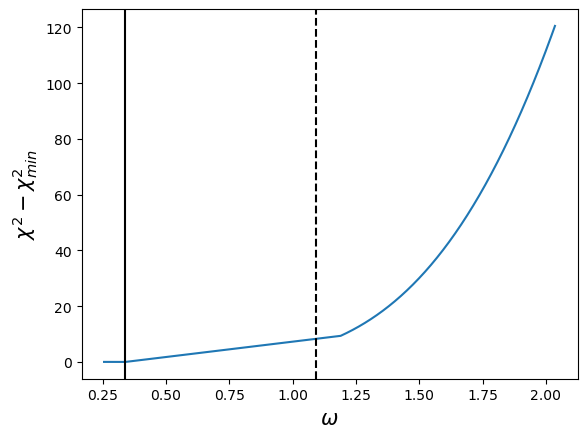

In [33]:
def Errors_CREAM(n):
    
    alpha1 = 2.79
    alpha2 = 2.62
    Eb1 = 0.275 * 1e3 #GeV
    omega1 = 0.34
    K = 4.4 * 10**(-2) #(GeV m2 s sr)-1
    output = minimize(Chi_CREAM, (K, alpha1, alpha2, omega1, Eb1), method='L-BFGS-B')
    best_fit_values = output['x']
    
    scan = np.zeros(500)
    fit = best_fit_values[n]
    for i in range(0, 250):
        scan[i] = fit - (fit / 1000)*i
    for j in range(250, 500):
        scan[j] = fit + (fit / 100)*j
    scan = np.sort(scan)
    
    true_best_fit = Chi_CREAM(best_fit_values)
    chi_sqrd = np.zeros(500)
    for k in range(0, 500):
        best_fit_values[n] = scan[k]
        scan_chi = Chi_CREAM(best_fit_values)
        chi_sqrd[k] = np.abs(true_best_fit - scan_chi)
    return scan, fit, chi_sqrd

# Error of width
scan, fit, chi_sqrd = Errors_CREAM(3)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('omega2'); print('Upper error:', scan_interval[0] - fit)

# Check chi^2 - chi^2_min distribution
plt.plot(scan, chi_sqrd)
plt.xlabel(r'$\omega$', fontsize=15)
plt.ylabel(r'$\chi^2 - \chi^2_{min}$', fontsize=15)
plt.axvline(x = fit, color='black')
plt.axvline(x = scan_interval[0], linestyle='--', color='black')

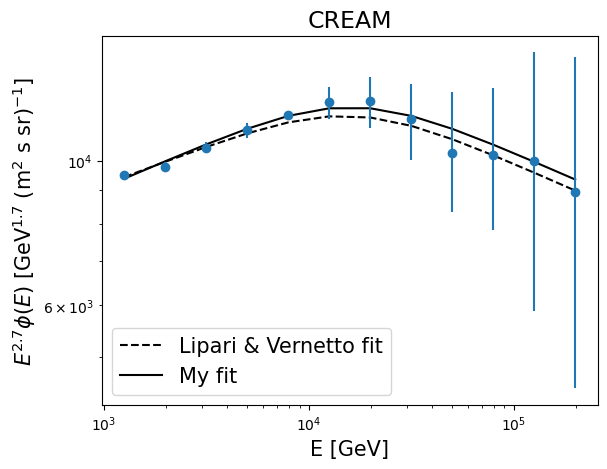

In [34]:
# Lipari & Vernetto
Phi_model = Phi_onebreak(E, K_bestfit_CREAM, 2 * 1e3, alpha2_bestfit_CREAM, alpha3_bestfit_CREAM, omega2_bestfit_CREAM, Eb2_bestfit_CREAM)
# Me
Phi_fit = Phi_onebreak(E, best_fit_values[0], 2 * 1e3, best_fit_values[1], best_fit_values[2], best_fit_values[3], best_fit_values[4])

plt.figure()
plt.plot(E, Phi_model * E**2.7, linestyle='--', color='black', label='Lipari & Vernetto fit')
plt.plot(E, Phi_fit * E**2.7, color='black', label='My fit')
plt.errorbar(E_CREAM[index], flux_CREAM[index] * E_CREAM[index]**2.7, yerr=(error_CREAM_low[index], error_CREAM_up[index]) * E_CREAM[index]**2.7, fmt='o')
plt.loglog()
plt.ylabel(r'$E^{2.7}\phi(E)$ [GeV$^{1.7}$ (m$^2$ s sr)$^{-1}$]', fontsize=15)
plt.xlabel('E [GeV]', fontsize=15)
plt.title('CREAM', fontsize=17)
plt.legend(fontsize=15)
plt.savefig('Fits/CREAM_fit.png')